In [12]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np
import functools
from einops import rearrange
import tqdm
import time

# Second-Order Optimization

Let's discuss optimization in the context of **second-order gradient descent**. The idea here is to use second-order gradient information in combination with first-order information to make more accurate update steps. The basic algorithm is also known as **Newton's method**. Examining the difference between first and second-order gradient updates:

$$
\begin{align}
\theta & \leftarrow \theta - \alpha \nabla_\theta \; L(\theta)  & & \text{(First-order gradient descent)}\\
\theta & \leftarrow \theta - \alpha H(\theta)^{-1} \nabla_\theta \; L(\theta)  & & \text{(Second-order gradient descent)}\\
\end{align}
$$

is the presence of the $H(\theta)^{-1}$ term. This is a matrix so important we give it a name, the **Hessian**, and it is the matrix of all pairwise second-order derivatives of $L(\theta)$. By scaling our gradients with the inverse Hessian, we get a number of nice properties (which we will examine shortly). The downside of course is the cost; calculating $H(\theta)$ itself is expensive, and inverting it even more so.

In the rest of this page, we'll look at:
- Interpretations of second-order descent
- Approximations to computing $H(\theta)^{-1}$ in classical optimization
- Approximations to computing $H(\theta)^{-1}$ in deep learning

## Second-order descent as preconditioning

A black-box way to view second-order descent is as a specific type of **preconditioning**. Recall that a preconditioner is a linear transformation of the gradient, often written as a matrix:

$$
\theta \leftarrow \theta - P \; \nabla_\theta \, L(\theta).
$$

We often want to use preconditioning when we want to update certain parameters at different speeds. For example, a diagonal preconditioner can be used to specify per-parameter learning rates. In classical optimization problems, this can be helpful is we know that e.g. certain inputs have a much higher magnitude, etc. The inverse Hessian ends up being the 'correct' way to precondition a gradient update using second-order information, as shown next.

## Second-order descent as solving a quadratic approximation

We can approximate the true loss function using a second-order Taylor series expansion:

$$
\tilde{L}(\theta + \theta') = L(\theta) + \nabla L(\theta)^{T}\theta' + \dfrac{1}{2} \theta'^{T} \nabla^2 L(\theta) \theta'.
$$

Assuming $\nabla^2 L(\theta)$ is invertible, we can now solve for the $\theta'$ that minimizes this approximate loss:

$$
\begin{align}
& \nabla \tilde{L}(\theta + \theta') = 0 \\
& \nabla L(\theta) + \nabla^2 L(\theta) \theta' = 0 \\
& \theta' = (\nabla^2 L(\theta))^{-1} \nabla L(\theta) \\
& \theta' = H(\theta)^{-1} \nabla L(\theta) \\
\end{align}
$$

which gives us our original second-order descent method. So, the (unscaled) second-order descent iteration is the same as jumping directly to a point that minimizes the quadratic approximation of the loss function. In practice, we often still take a smaller step to account for approximation errors.

## Second-order descent as knowing how far to step

A key property of the Hessian of *convex functions* is that it is positive definite -- in other words, matrix multiplying will never flip the sign of a vector. Even for non-convex functions, we can apply regularization such that the Hessian always remains positive definite. So, second-order descent is **sign preserving** and will update each parameter in the same direction as first-order descent. The difference is in how *much* the parameter is updated. 


## Example: 2D Classical Optimization

Let's examine how various second-order methods work on a simple 2D optimization problem. We'll use a fourth-order polynomial loss function, which is convex but not as simple as a quadratic. As a sanity check, gradient descent can find the minimum within 15 iterations or so:

In [13]:
def loss_fn(z):
    x, y = z
    y = y * 2
    x = x * 0.8 - 0.5
    x_polynomials = jnp.array([x ** (i+1) for i in range(4)])
    y_polynomials = jnp.array([y ** (i+1) for i in range(4)])
    all_polynomials = jnp.concatenate([x_polynomials, y_polynomials])
    multipliers = jax.random.uniform(jax.random.PRNGKey(1), (8,))
    multipliers = multipliers.at[3].set(1)
    multipliers = multipliers.at[7].set(1)
    return jnp.dot(all_polynomials, multipliers) + 0.1 * (x * y)

def plot_optim(optim_fn, opt_state, steps=15):
    iter_points = []
    z = jnp.array([-0.9, 0.4])
    for i in range(steps):
        iter_points.append(z)
        z, opt_state = optim_fn(z, opt_state, loss_fn)

    # Create a grid of points
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-0.5, 0.5, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.stack([X.flatten(), Y.flatten()], axis=-1)
    Z = jax.vmap(loss_fn)(XY)
    Z = Z.reshape(X.shape)

    # Create the plot
    plt.figure(figsize=(6, 3))
    contour = plt.contour(X, Y, Z, levels=30, cmap='viridis', alpha=0.4)
    plt.clabel(contour, inline=True, fontsize=8)

    iter_points = np.array(iter_points)
    plt.plot(iter_points[:, 0], iter_points[:, 1], 'ro-')
    plt.xticks([])
    plt.yticks([])
    plt.show()

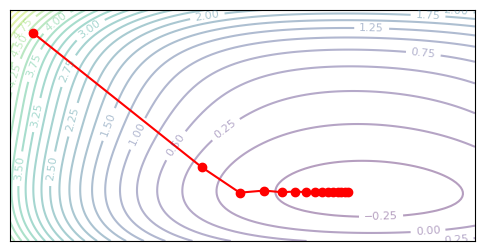

In [14]:
@functools.partial(jax.jit, static_argnums=(2,))
def gradient_descent(z, opt_state, loss_fn):
    grad_z = jax.grad(loss_fn)(z)
    new_z = z - 0.1 * grad_z
    opt_state = None
    return new_z, opt_state
plot_optim(gradient_descent, None)

Note how learning slows down near the minimum, as the absolute scale of the gradient also approaches zero. Second-order methods provide a way to correct for this.

## Newton's Method

Now, we'll implement an iterative version of Newton's method. Remember that Newton's method is equivalent to finding the solutions to a quadratic approximation of the loss. If the true loss is quadratic, we can solve the problem in a single step. Our loss is not quadratic (it's a fourth-order polynomial), so we need to use an *iterative* version of Newton's method, with a smaller step size.

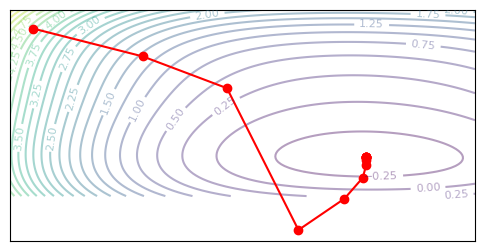

In [15]:
@functools.partial(jax.jit, static_argnums=(2,))
def newton_descent(z, opt_state, loss_fn):
    grad_z = jax.grad(loss_fn)(z)
    hessian_z = jax.hessian(loss_fn)(z)
    new_z = z - 0.8 * (jnp.linalg.inv(hessian_z) @ grad_z)
    opt_state = None
    return new_z, opt_state
plot_optim(newton_descent, None)

Cool, we learn pretty fast, but we also end up overshooting the optimal parameters. The danger of Newton's method is that we can end up taking larger steps than we mean to, since our Hessian is only locally accurate.

## Regularized Newton

An intuitive way to look at Newton's method is that by scaling our gradient by the inverse Hessian, we can take larger steps in flatter directions, since those steps should have a smaller overall effect. The problem any errors in the Hessian have the potential to drastically overstep.

One way to regularize the Newton update is to **dampen** the update and penalize movement in flatter directions. We can do this by adding an identity matrix to the Hessian. This addition is similar to enforcing a maximum flatness -- even if the Hessian estimates a direction as extremely flat, we will treat it as somewhat sloped to prevent excessive updates.

The regular Newton and the dampened Newton behave similarly at high curvature, but at lower curvature, the dampened Newton will behave more conseratively. This lets us safely increase our learning rate.

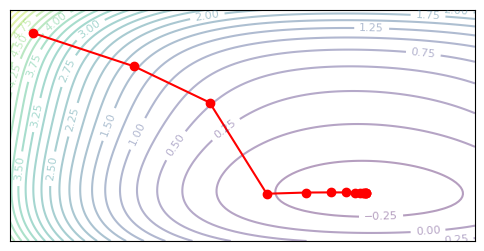

In [16]:
@functools.partial(jax.jit, static_argnums=(2,))
def damped_newton_descent(z, opt_state, loss_fn):
    grad_z = jax.grad(loss_fn)(z)
    hessian_z = jax.hessian(loss_fn)(z)
    new_z = z - 0.8 * (jnp.linalg.inv(hessian_z + jnp.eye(2) * 1) @ grad_z)
    opt_state = None
    return new_z, opt_state
plot_optim(damped_newton_descent, None)

## Trust Region Newton

As we saw above, a pain point with Newton methods is that the Hessian is not always well-behaved. If the diagonal values are too small, we can run into numerical issues, and a non-positive-definite Hessian can even cause us to move in a direction that *increases* loss. A more stable way to use second-order information is to view second-order information as enforcing a **trust region** over first-order descent. We will minimize first-order loss, subject to a constraint that on the change in parameters.

$$
\Delta \theta = \text{argmin}_{\Delta \theta} \tilde{L}(\theta + \Delta \theta) \qquad \text{st.} \qquad d(\theta, \theta + \Delta \theta) < \Delta
$$

Note that $\tilde{L}$ is the first-order approximation of $L$. As a linear function, the argmin of this approximation lies at infinity, so we need an appropriate constraint to have a viable algorithm. In naive gradient descent, we simply use a small learning rate to approximate a trust region.

Let's define a better trust region. We know that the Hessian represents second-order behavior of a change in parameters, so we can use the Hessian to define a notion of distance. To make things easier, we can use the **absolute value eigenvalue form** $|H|$, which upper bounds the normal $H$.
```{margin}
For any $H$, $|x^T H x| < x^T |H| x$, where $|H|$ is the result of decomposing $H$ into its eigenbasis, then taking the absolute value of each eigenvalue and reconstructing $H$.
```

$$
d(\theta, \theta + \Delta \theta) = \Delta \theta^T |H| \Delta \theta < \Delta
$$

In fact, the solution to the constrained problem above is the same as Newton's method, but we use the absolute value eigenvalue form of H, which is always positive-definite. Intuitively, we use the magnitude of the second-order behavior, but enforce that the sign of the gradient remains the same. 

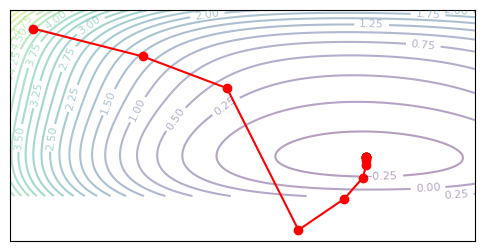

In [17]:
@functools.partial(jax.jit, static_argnums=(2,))
def trust_region_newton(z, opt_state, loss_fn):
    grad_z = jax.grad(loss_fn)(z)
    hessian_z = jax.hessian(loss_fn)(z)
    eigvals, eigvecs = jnp.linalg.eigh(hessian_z)
    eigvals = jnp.abs(eigvals)
    hessian_psd = jnp.dot(eigvecs, jnp.dot(jnp.diag(eigvals), eigvecs.T)).real
    new_z = z - 0.8 * (jnp.linalg.inv(hessian_psd) @ grad_z)
    opt_state = None
    return new_z, opt_state
plot_optim(trust_region_newton, None)

**Null result**. In our 2D example here, the trust region and Newton method are actually just the same, since $H$ is always positive-definite along our optimizaztion path. The existence of saddle points scales with dimensionality, and in a 2D example they are rare or nonexistent. In high-dimensional problems, the trust region approach may provide a benefit. An important result is that in the toy case, the trust region approach *does not harm* learning, thus the absolute-value approximation is reasonable.

## BFGS

Now, we will examine a class of methods known as **quasi-Newton** methods, which do not construct the exact Hessian but rather an approximation of it. The main idea in BFGS is to use finite difference methods to approximate the Hessian. We're already taking first-order gradients, and by viewing the resulting affect on the loss of applying these gradients, we can get an estimate of the second-order behavior.
```{margin}
BFGS is named for Broyden, Fletcher, Goldfarb, and Shanno, the independent creators of the algorithm.
```

Let's start with a simple relation. We want to find a matrix $\tilde{H}$ that approximates the true Hessian $H$. We know that such a matrix should satisfy the **finite-difference relation**:

$$
\tilde{H} \Delta \theta = \nabla L(\theta + \Delta \theta) - \nabla L(\theta) \qquad \text{or} \qquad \tilde{H} \Delta \theta = \Delta g
$$

where $g = \nabla L(\theta)$ represents gradients. The equation states that under any change $\Delta \theta$, the matrix $\tilde{H}$ should accurately represent the corresponding change in *gradients*. The true Hessian satisfies this condition by definition.

Now, we will find a strategy to discover $\tilde{H}$ in an iterative manner. We want $\tilde{H}$ to always be symmetric and positive-definite -- as we saw in the previous sections, this makes for a well-behaved distance. Let's go over a simple iteration. When we take a gradient step, we can evaluate the gradient before and after the parameter change, giving us the $\Delta \theta$ and $\Delta g$ terms above. So, we should update our estimate $\tilde{H}$ to solve this new equation. There are many possible $\tilde{H}$ which solve the system, but we can add a constraint that the change in $\tilde{H}$ is rank 1.

This gives us the **Broyden formula**. We want to find $v$ such that $\tilde{H} + vv^T$ satisfies the finite-difference relation. Solving it out:

$$
\begin{align}
    & \tilde{H}' = \tilde{H} + vv^T \qquad \text{st.} \qquad (\tilde{H} + vv^T) \Delta \theta = \tilde{H} \Delta \theta + vv^T \Delta \theta = \Delta g \\
    & \tilde{H}' = \tilde{H} + \frac{(\tilde{H} \Delta \theta - \Delta g)(\tilde{H} \Delta \theta - \Delta g)^T}{(\tilde{H} \Delta \theta - \Delta g)^T \Delta \theta} 
\end{align}
$$ 

which gives the corresponding rank-1 update to $\tilde{H}$. The problem this this approach is that we do not have a guarantee that $\tilde{H}$ remains positive definite.

The **BFGS formula** gives a rank-2 update that retains positive definiteness:

$$
\begin{align}
    & \tilde{H}' = \tilde{H} + \frac{(\Delta g)(\Delta g)^T}{(\Delta g)^T(\Delta \theta)} - \frac{\tilde{H} (\Delta \theta) (\Delta \theta)^T \tilde{H}}{(\Delta \theta)^T \tilde{H} (\Delta \theta)}
\end{align}
$$ 

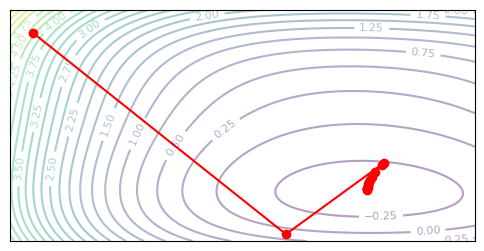

In [18]:
# @functools.partial(jax.jit, static_argnums=(2,))
def bfgs(z, opt_state, loss_fn):
    H = opt_state
    grad_z = jax.grad(loss_fn)(z)
    # Real BFGS should search for the optimal step size, but we'll just use a fixed one
    dz = -0.15 * (jnp.linalg.inv(H) @ grad_z)
    new_z = z + dz
    grad_newz = jax.grad(loss_fn)(new_z)
    dg = grad_newz - grad_z
    H_new = H + (jnp.outer(dg, dg) / jnp.dot(dg, dz)) \
              - (jnp.outer(jnp.dot(H, dz), jnp.dot(H, dz)) / jnp.dot(dz, jnp.dot(H, dz)))
    return new_z, H_new
plot_optim(bfgs, jnp.eye(2))

The **L-BFGS (Limited-memory BFGS) formula** lets us save memory on our Hessian estiamte. In the BFGS algorithm above, we store the entire $\tilde{H}$ matrix, and invert it at every iteration. Both of these are expensive criteria that we would perfer to remove. Instead, let's see if we can get away with only storing a low-rank approximation of the *inverse* Hessian directly.

The idea in L-BFGS is to keep the last $M$ parameter-gradient pairs in memory, and use them to iteratively update our current gradient to mimic the effect of multiplying by the inverse Hessian. This is commonly achieves using the **two-loop recursion** approach, which first constructs scalars $a_i$ and a vector $q$, then uses them to construct the final update $H^{-1} g$.

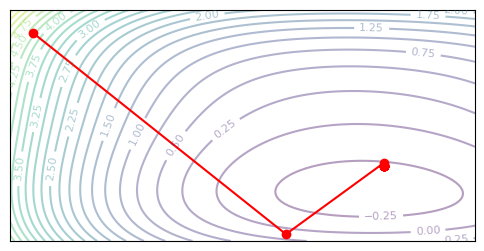

In [19]:
def lbfgs(z, opt_state, loss_fn):
    dzs, dgs = opt_state
    grad_z = jax.grad(loss_fn)(z)
    grad_z_raw = grad_z

    # Compute H^-1 grad_z via L-BFGS approximation.
    alphas = []
    for i in range(len(dzs)):
        alpha = jnp.dot(dzs[i], grad_z) / jnp.dot(dzs[i], dgs[i])
        grad_z = grad_z - alpha * dgs[i]
        alphas.append(alpha)
    Hz = grad_z # Starting guess for (H^-1 grad_z) is a constant scale.
    for i in reversed(range(len(dzs))):
        beta = jnp.dot(dgs[i], Hz) / jnp.dot(dzs[i], dgs[i])
        Hz = Hz + (alphas[i] - beta) * dzs[i]
        
    # Real BFGS should search for the optimal step size, but we'll just use a fixed one
    dz = -0.15 * Hz
    new_z = z + dz
    dg = jax.grad(loss_fn)(new_z) - grad_z

    dzs = [dz] + dzs
    dgs = [dg] + dgs
    return new_z, (dzs, dgs)
plot_optim(lbfgs, ([], []), steps=15)

In the precise form, the BFGS and L-BFGS should use a line search to look for the optimal step size. In our implementation I opted to just use a constant step size instead for simplicity. The methods both seem to work after playing with hyperparameters, but numerical issues seem to arise when near the solution. I found that the approximate Hessian often estimates a high curvature, resulting in the second-order update becoming too small near the end -- see the L-BFGS trajectory which does not converge to the minimum.

## Diagonal Newton

Another approximation we can try is to only use the **diagonal values** of the Newton. This is an n-length vector, rather than an `n,n` matrix. It coresponds exactly to the second-order derivatives of each parameter, without modelling the pairwise interactions. If we know that each parameter has a roughly independent effect on the loss, then a diagonal approximation can be a good idea.
```{margin}
The true Hessian for our example problem is
\begin{verbatim}
[[12.3  0.16]
[0.16   31.6]]
\end{verbatim}
```

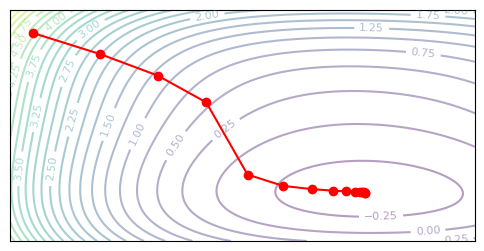

In [20]:
@functools.partial(jax.jit, static_argnums=(2,))
def diagonal_newton_descent(z, opt_state, loss_fn):
    grad_z = jax.grad(loss_fn)(z)

    def vgrad(f, x): # Second-order gradient (diagonal of Hessian)
        y, vjp_fn = jax.vjp(f, x)
        return vjp_fn(jnp.ones(y.shape))[0]
    grad2_z = vgrad(lambda x: vgrad(loss_fn, x), z)
    update = (1 / grad2_z) * grad_z
    new_z = z - 0.5 * update

    opt_state = None
    return new_z, opt_state
plot_optim(diagonal_newton_descent, None)

Hessian [[12.377451    0.16000001]
 [ 0.16000001 31.63279   ]]

## Example: CIFAR-10 Classification

Let's move on to an example training real neural networks. Continuing from previous pages, we'll train a small vision transformer to classify CIFAR-10. We will first run a baseline with standard gradient descent.

- First-Order SGD
- Second-Order (slow)
- Gauss-Newton
- Natural Gradient
- KFAC
- Shampoo
- Adam as ...

In [21]:
from keras.datasets import cifar10
(train_images, train_labels), (valid_images, valid_labels) = cifar10.load_data()

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = jnp.arange(embed_dim // 2, dtype=jnp.float32) / (embed_dim // 2)
    omega = 1. / 10000**omega  # (D/2,)
    pos = pos.reshape(-1)  # (M,)
    out = jnp.einsum('m,d->md', pos, omega)  # (M, D/2), outer product
    emb = jnp.concatenate([jnp.sin(out), jnp.cos(out)], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, length):
    grid_size = int(length ** 0.5)
    assert grid_size * grid_size == length
    grid_hw = jnp.arange(grid_size, dtype=jnp.float32)
    grid = jnp.stack(jnp.meshgrid(grid_hw, grid_hw), axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    pos_embed = jnp.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return jnp.expand_dims(pos_embed, 0) # (1, H*W, D

class TinyViT(nn.Module):
    features: int = 128
    patch_size: int = 8
    num_classes: int = 10
    dropout: float = 0.3

    @nn.compact
    def __call__(self, x, deterministic=False):
        patch_tuple = (self.patch_size, self.patch_size)
        num_patches = (x.shape[1] // self.patch_size)
        x = nn.Conv(self.features, patch_tuple, patch_tuple, use_bias=True, padding="VALID")(x) # Patch Embed
        x = rearrange(x, 'b h w c -> b (h w) c', h=num_patches, w=num_patches)
        x = x + get_2d_sincos_pos_embed(self.features, num_patches**2)
        x = jnp.concatenate([x, nn.Embed(1, self.features)(jnp.zeros((x.shape[0], 1), dtype=jnp.int32))], axis=1) # Class Token
        for _ in range(4):
            y = nn.LayerNorm()(x)
            y = nn.MultiHeadDotProductAttention(num_heads=4, dropout_rate=self.dropout, deterministic=deterministic)(y, y)
            x = x + y
            y = nn.LayerNorm()(x)
            y = nn.Dense(self.features * 2)(y)
            y = nn.gelu(y)
            y = nn.Dropout(rate=self.dropout, deterministic=deterministic)(y)
            y = nn.Dense(self.features)(y)
            y = nn.Dropout(rate=self.dropout, deterministic=deterministic)(y)
            x = x + y
        x = x[:, 0]
        x = nn.Dense(self.num_classes)(x)
        return x

def sample_batch(key, batchsize, images, labels):
    idx = jax.random.randint(key, (batchsize,), 0, images.shape[0])
    return images[idx], labels[idx]

def zero_params(params):
    return jax.tree_map(lambda x: jnp.zeros_like(x), params)

def train_cifar(optimizer_fn, init_opt_fn, max_steps, batch_size=128):
    train_losses = []
    classifier = TinyViT()
    key = jax.random.PRNGKey(0)
    key, param_key = jax.random.split(key)
    v_images, v_labels = sample_batch(param_key, 256, valid_images, valid_labels)
    params = classifier.init({'params': param_key, 'dropout': param_key}, v_images)['params']
    opt_state = init_opt_fn(params)

    @jax.jit
    def update_fn(key, params, opt_state, images, labels, step):
        def loss_fn(p, x, y):
            onehot_labels = jax.nn.one_hot(y[:, 0], 10)
            logits = classifier.apply({'params': p}, x/255.0, rngs={'dropout': key}, deterministic=False)
            loss = jnp.mean(jnp.sum(-nn.log_softmax(logits) * onehot_labels, axis=-1))
            return loss
        loss_fn_partial = functools.partial(loss_fn, x=images, y=labels)
        logit_fn_partial = lambda p : classifier.apply({'params': p}, images/255.0, rngs={'dropout': key}, deterministic=False)
        loss, params, opt_state = optimizer_fn(params, opt_state, loss_fn_partial, labels=labels, step=step, logit_fn=logit_fn_partial)
        return loss, params, opt_state
    for i in tqdm.tqdm(range(max_steps)):
        key, data_key, update_key = jax.random.split(key, 3)
        images, labels = sample_batch(data_key, batch_size, train_images, train_labels)
        loss, params, opt_state = update_fn(update_key, params, opt_state, images, labels, i)
        train_losses.append(np.array(loss))
    return np.array(train_losses)

def plot_losses(losses, labels, title, colors=None, ylim=2):
    fig, axs = plt.subplots(1, figsize=(5, 3))
    for i, (label, loss) in enumerate(zip(labels, losses)):
        loss = np.convolve(loss, np.ones(100), 'valid') / 100
        axs.plot(loss, label=label, color=colors[i] if colors else None)
    axs.legend()
    axs.set_ylim(-0.05, ylim)
    axs.set_title(title)
    plt.show()

100%|██████████| 20000/20000 [00:47<00:00, 422.58it/s]


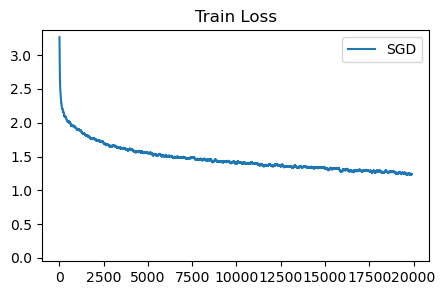

In [22]:
def sgd(params, opt_state, loss_fn, **kwargs):
    loss, grads = jax.value_and_grad(loss_fn)(params)
    lr = 0.01
    new_params = jax.tree_map(lambda p, u: p - lr * u, params, grads)
    return loss, new_params, None
init_opt_fn = lambda p : None

sgd_loss = train_cifar(sgd, init_opt_fn, 20_000)
plot_losses([sgd_loss], ['SGD'], 'Train Loss', ylim=None)

## Diagonal Newton

Classical Newton's method cannot be applied to neural networks due to memory requirements. Our small model has around 400k parameters, making the Hessian a matrix of over 160 million parameters. We cannot construct such a matrix, let alone invert it. 

An approximation that is easier to handle is the **diagonal Newton's method**, which takes the second-order gradients of each individual parameter (ignoring pairwise interactions), then scales the gradient by the inverse. The intution is to increase step-size at areas with low curvature. It is equivalent to setting all entires of the Hessian to zero except those on the diagonal.

Immediately a problem arises -- neural networks often have **zero curvature**. Our network uses ReLU activations, which have a second-order derivative of 0. This means that for a large portion of parameters, the diagonal Hessian may contain zeros, and dividing by zero scales up our update to infinity. We can bandage this problem by clipping the diagonal Hessian to remain positive.

100%|██████████| 20000/20000 [02:09<00:00, 154.61it/s]


[5.3107767 5.0005608 5.6169114 6.0569983 6.50208   7.410034  5.540567
 5.760478  4.5348625 4.385929 ]


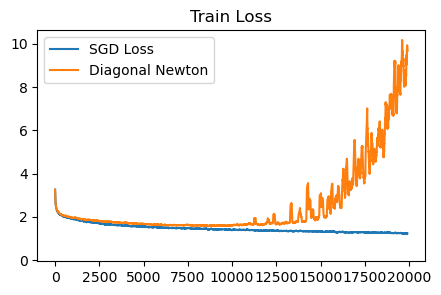

In [23]:
def diagonal_newton_sgd(params, opt_state, loss_fn, **kwargs):
    def vgrad(f, x): # Second-order gradient (diagonal of Hessian)
        y, vjp_fn = jax.vjp(f, x)
        return vjp_fn(jax.tree_map(lambda p: jnp.ones_like(p), y))[0]
    loss, grads = jax.value_and_grad(loss_fn)(params)

    grad2 = vgrad(lambda x: vgrad(loss_fn, x), params)
    grad2 = jax.tree_map(lambda x: jnp.clip(x, 0.5, 3), grad2) # Clip to reasonable values
    updates = jax.tree_map(lambda g, h: g / h, grads, grad2)
    updates = jax.tree_map(lambda x: jnp.clip(x, -0.5, 0.5), updates) # Clip to reasonable values

    lr = 0.01
    new_params = jax.tree_map(lambda p, u: p - lr * u, params, updates)
    return loss, new_params, None
init_opt_fn = lambda p : None

diagonal_newton_loss = train_cifar(diagonal_newton_sgd, init_opt_fn, 20_000)
print(diagonal_newton_loss[:10])
plot_losses([sgd_loss, diagonal_newton_loss], ['SGD Loss', 'Diagonal Newton'], 'Train Loss', ylim=None)

This diagonal Newton method is not very good. It requires careful clipping of the Hessian and the updates, otherwise the training runs diverge. 

## AdaHessian

Second-order methods are sensitive to noise. When we do stochastic gradient descent, there is inherent noise in the batch we sample. For first-order methods the noise is not really a problem, but in second-order methods, the noise can lead to inaccurate Hessian estimation and catastrophic steps. **AdaHessian** proposes a momentum-based technique, namely, a running average of the diagonal Hessian is used.

100%|██████████| 20000/20000 [02:03<00:00, 161.62it/s]


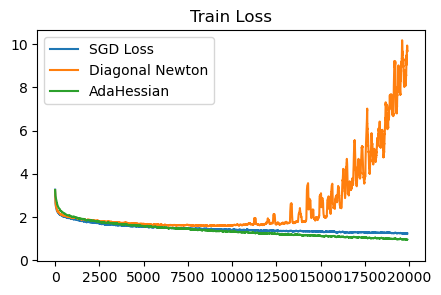

In [24]:
def adahessian(params, opt_state, loss_fn, step, **kwargs):
    grad2_momentum = opt_state
    def vgrad(f, x): # Second-order gradient (diagonal of Hessian)
        y, vjp_fn = jax.vjp(f, x)
        return vjp_fn(jax.tree_map(lambda p: jnp.ones_like(p), y))[0]
    loss, grads = jax.value_and_grad(loss_fn)(params)

    grad2 = vgrad(lambda x: vgrad(loss_fn, x), params)
    b2 = 0.999
    grad2_momentum = jax.tree_map(lambda v, g: b2 * v + (1-b2) * g**2, grad2_momentum, grad2)
    grad2_hat = jax.tree_map(lambda v: v / (1 - b2 ** (step + 1)), grad2_momentum)
    updates = jax.tree_map(lambda g, h: g / (jnp.sqrt(h) + 1e-6), grads, grad2_hat) 

    lr = 0.015
    new_params = jax.tree_map(lambda p, u: p - lr * u, params, updates)
    return loss, new_params, grad2_momentum
init_opt_fn = lambda p : zero_params(p)

adahessian_loss = train_cifar(adahessian, init_opt_fn, 20_000)
plot_losses([sgd_loss, diagonal_newton_loss, adahessian_loss], ['SGD Loss', 'Diagonal Newton', 'AdaHessian'], 'Train Loss', ylim=None)

AdaHessian is much better than diagonal Newton. Using momentum to smooth out the diagonal Hessian estimation seems to be key. Without it, at some point in training the updates will diverge. We are also able to remove the manual clipping on the Hessian without any issues.

## Generalized Gauss-Newton

The **Generalized Gauss-Newton** method gives us another way of approximating the Hessian, this time as a sum of outer products. Let us break up our full function into two components: the network $N$ and the loss $L$, which we can write as $L(N(\theta))$. The full Hessian decomposes into two terms:

```{margin}
The original Gauss-Newton deals with mean-squared error loss functions. The *Generalized* Gauss-Newton extends its findings onto a broader class of functions (cross-entropy loss for classification in our case). For MSE loss, $H_L$ is simply the identity matrix and can be ignored.
```

$$
H = \nabla (J_L J_N) = \underbrace{J_{N}^T H_L J_N}_{\text{Gauss-Newton term}} + \; \underbrace{\sum (J_{L})_i H_{Ni}}_{\text{Dropped terms}}
$$

where $J$ represents the Jacobian matrix of first-order derivatives. 

The Gauss-Newton approximation drops the second term, keeping only the first. Note how the second term contains $H_{Ni}$, which is the Hessian of the neural network -- by omitting this term, the Gauss-Newton approximation becomes significantly easier to calculate. The first term contains only the first-order Jacobians, along with the Hessian of the loss function, which is simple and known in analytical form. The Hessian of softmax cross-entropy loss is $diag(z) - zz^T$, where $z$ is the vector of logits. The first term is also guaranteed to be positive semi-definite.

https://arxiv.org/abs/2405.14402

To efficiently locate descent under Gauss-Newton, we opt to construct a low-rank approximation to the matrix. The Gauss-Newton matrix $G$ calculated over a batch of size $b$ has a rank of at most $b$, so we can locate the solution of $G^{-1} \nabla_\theta$ in an efficient way. The decomposition is at follows:

$$
\nabla_\theta = J^T (z - \text{onehot}(y)) \qquad \text{and} \qquad G = J^T H J \\
\begin{align}
u & = G^{-1} \nabla_\theta \\
& = (J^T H J)^{-1} J^T (z - \text{onehot}(y)) \\
& = J^T (H JJ^T)^{-1} (z - \text{onehot}(y)) \\
\end{align}
$$

100%|██████████| 20000/20000 [17:35<00:00, 18.95it/s]


[5.3678956 4.4173384 4.3356314 ... 2.0501223 2.140688  1.8370565]


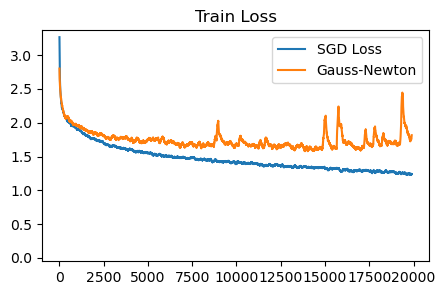

In [25]:
import jax.flatten_util

def gauss_newton(params, opt_state, loss_fn, logit_fn, labels, **kwargs):
    flat_params, unravel_fn = jax.flatten_util.ravel_pytree(params)
    logit_fn_flat = lambda p: logit_fn(unravel_fn(p))
    
    # Jacobian of logits, cross-entropy residuals, and loss.
    logits = logit_fn(params)
    probs = jax.nn.softmax(logits) # (B, C)
    onehot_labels = jax.nn.one_hot(labels[:, 0], 10)
    residuals = jnp.reshape(probs - onehot_labels, (-1,))
    loss = jnp.mean(jnp.sum(-jnp.log(probs) * onehot_labels, axis=-1))

    # Construct low-rank Gauss-Newton approximation.
    J = jax.jacobian(logit_fn_flat)(flat_params)
    J = jnp.reshape(J, (J.shape[0] * J.shape[1], -1))
    flat_probs = jnp.reshape(probs, (-1,))
    H_l = jnp.diag(flat_probs) - jnp.outer(flat_probs, flat_probs)
    G = H_l @ J @ J.T
    G = G + jnp.eye(J.shape[0]) * 0.8 # Damping

    # Solve for update direction.
    updates_flat = J.T @ jnp.linalg.solve(G, residuals)
    updates = unravel_fn(updates_flat)

    lr = 0.01
    new_params = jax.tree_map(lambda p, u: p - lr * u, params, updates)
    # jax.debug.print('loss {x}', x=loss)
    return loss, new_params, None
init_opt_fn = lambda p : None

gauss_newton_loss = train_cifar(gauss_newton, init_opt_fn, 20_000, batch_size=32)
print(gauss_newton_loss)
plot_losses([sgd_loss, gauss_newton_loss], ['SGD Loss', 'Gauss-Newton'], 'Train Loss', ylim=None)

Unfortunately, the results don't seem great (even with a decent attempt at tuning). They are better than the diagonal Newton. Perhaps, similar to AdaHessian, a running average of the Gauss-Newton is required? However due to the specific low-rank form we use, it is tricky to maintain this average.

## Natural Gradient

The **natural gradient** is a way to precondition our gradient updates by taking the steepest directions under a KL divergence metric. Notably, descent under this metric is **invariant to parametermization** -- the same update should be achieved no matter how the internal architecture of the network. We can do this by preconditioning using the **Fisher information matrix**, a second-order approximation of KL divergence:
$$
D_{KL}(p(y|\theta) || p(y|\theta') \approx F = E_{y \sim p} \left[ (\nabla_\theta \log p (y|\theta)) (\nabla_\theta \log p (y|\theta))^T \right]
$$

where $y$ denotes the output of the neural network. Generally in machine learning this term is computed in an expectation over inputs $x$ as well, setting $p(y|\theta) \rightarrow p(y|x,\theta)$.

As it turns out, the natural gradient form for MSE and cross-entropy loss functions are equivalent to the generalzed Gauss-Newton form we described above. The expectation $E_{y \sim p}$ is taken over the minibatch, and the inner form becomes $J_N^T F_L J_N$. For cross-entropy, $H_L = F_L = \text(diag(z)) - zz^T$, same as above. So we have no experiment to run here.
```{margin}
For MSE, $H_L = F_L = I$.
```

(https://arxiv.org/pdf/1301.3584)

## Kronecker-Factored Apprixmation (K-FAC)

K-FAC is another approach for estimating the natural gradient. In the above implementation, we efficiently inverted the Fisher by using its low-rank form per batch. K-FAC does not assume this low rank structure, so it's helpful in cases where we have large batch sizes, or more commonly, when we want to estimate the Fisher using a series of past updates, which greatly increases the estimation accuracy. K-FAC divides the inverse Fisher into blocks, where each block contains all parameters for a *single layer*. 


After this: Adagrad as a second-order natural gradient method. Then variants: Adam, Shampoo.

#### References

https://www.lix.polytechnique.fr/bigdata/mathbigdata/wp-content/uploads/2014/09/notes_quasi_newton.pdf

https://www.deeplearningbook.org/contents/optimization.html

http://www.athenasc.com/nonlinbook.html

https://arxiv.org/abs/1706.03662 (on the second-order behavior of relu networks)

https://arxiv.org/abs/1905.12558 (empirical fisher vs fisher)